In [11]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_percentage_error
rcParams['figure.figsize'] = 20,10
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv('inception_utensil_color_bias_TEA_SPOON_effect.csv')

In [2]:
graph_types = [
    'bk_obj_color',
    'bk_obj_color_shape',
    'bk_part_obj_color',
    'bk_part_obj_color_shape',
    'cds_obj_color',
    'cds_obj_color_shape',
    'cds_part_obj_color',
    'cds_part_obj_color_shape',
]
modelnames = [
    'inception_imageneta_bias',
    'squeezenet_imageneta_bias',
    'inception_utensil_color_bias',
    'inception_utensil_shape_bias',
    'inception_utensil_both_bias',
    'squeezenet_utensil_both_bias',
    'squeezenet_utensil_color_bias',
    'squeezenet_utensil_shape_bias'
    
]
imagenet_classes = [
    'ants',
    'mantis',
    'bees'
]
utensil_classes = [
    'TEA_SPOON',
    'FISH_SLICE',
    'DINNER_CUTLERY'
]

In [546]:
final_results = []

In [547]:
for gt in graph_types:
#     Path(+gt).mkdir(parents=True, exist_ok=True)
    for modelname in modelnames:
        if 'imagenet' in modelname:
                classnames = imagenet_classes
        else:
            classnames = utensil_classes
        for classname in classnames:
            filename = modelname+'_'+classname+'.csv'
            df = pd.read_csv(gt+'/effects/'+filename)
            top = df.sort_values(by='score', ascending=False)[:5]
            top = top.round(2)
            top = top.replace('primary_concept_','',regex=True)
            top['t'] = top['treatment']+'('+top['score'].astype(str)+')'
            t = top['t'][:5].values
            outp = ','.join(t)
            res = {}
            
            res['gt'] = gt
            res['modelname'] = modelname
            res['classname'] = classname
            res['outs'] = outp
            final_results.append(res)
            

In [549]:
final_results
fd = pd.DataFrame(final_results)
fd.to_csv('final_results_for_paper.csv',index=False)

In [550]:
fd.head()

,gt,modelname,classname,outs
0,bk_obj_color,inception_imageneta_bias,ants,"plastic_box(0.68),notebook(0.68),leaf(0.64),wh..."
1,bk_obj_color,inception_imageneta_bias,mantis,"dog(1.31),tree(0.65),mantis(0.61),storage_box(..."
2,bk_obj_color,inception_imageneta_bias,bees,"color_beige(0.76),camera(0.7),bicycle(0.67),be..."
3,bk_obj_color,squeezenet_imageneta_bias,ants,"keyboard(1.0),grass(0.93),petri_dish(0.91),inf..."
4,bk_obj_color,squeezenet_imageneta_bias,mantis,"basket(0.97),photo(0.74),color_skin(0.73),hous..."


import pandas as pd
import glob
import os

## calculate top 1 accuracy positive

In [526]:
li = []
for gt in graph_types:
    all_files = glob.glob('cv_with_shapes/'+gt+'/*.csv')
    for filename in all_files:
        pos_file = filename
        df_pos = pd.read_csv(filename)
        df_pos.drop(columns=['Unnamed: 0'],inplace=True)
        df_pos = df_pos[['gt','modelname','classname','accuracy','accuracy_2']]
        li.append(df_pos)

In [527]:
frame = pd.concat(li, axis=0, ignore_index=True)

In [532]:
frame.head()

,gt,modelname,classname,accuracy,accuracy_2
0,bk_obj_color,inception_utensil_shape_bias,TEA_SPOON,0.0,0.000
1,bk_obj_color,inception_utensil_shape_bias,TEA_SPOON,0.0,0.500
2,bk_obj_color,inception_utensil_shape_bias,TEA_SPOON,0.0,0.375
3,bk_obj_color,inception_utensil_shape_bias,TEA_SPOON,0.0,1.000
4,bk_obj_color,inception_utensil_shape_bias,TEA_SPOON,0.5,1.000


In [533]:
acc = frame[['gt','modelname','accuracy','accuracy_2']].groupby(by = ['gt','modelname']).agg(['mean','std'])
acc = acc.round(2)
acc.to_csv('accuracy_final_shape.csv')

## calculate top 1 accuracy negative

In [494]:
df = pd.read_csv('accuracy_final_shape.csv')

In [495]:
df.head()

,gt,modelname,classname,accuracy,accuracy2,accuracy_neg,accuracy2_neg
0,bk_obj_color,inception_utensil_shape_bias,TEA_SPOON,0.0,0.000,0.000000,0.000000
1,bk_obj_color,inception_utensil_shape_bias,TEA_SPOON,0.0,0.500,0.000000,0.250000
2,bk_obj_color,inception_utensil_shape_bias,TEA_SPOON,0.0,0.375,0.000000,0.000000
3,bk_obj_color,inception_utensil_shape_bias,TEA_SPOON,0.0,1.000,0.111111,0.666667
4,bk_obj_color,inception_utensil_shape_bias,TEA_SPOON,0.5,1.000,0.000000,0.200000


In [485]:
li = []
for gt in graph_types:
    all_files = glob.glob('cv_with_shapes_negative/'+gt+'/*.csv')
    for filename in all_files:
        pos_file = filename
        df_neg = pd.read_csv(filename)
        df_neg.drop(columns=['Unnamed: 0'],inplace=True)
        df_neg = df_neg[['gt','modelname','classname','accuracy','accuracy_2']]
        li.append(df_neg)

In [486]:
frame_neg = pd.concat(li, axis=0, ignore_index=True)

In [483]:
acc = frame[['gt','modelname','accuracy','accuracy_2']].groupby(by = ['gt','modelname']).agg(['mean','std'])
acc = acc.round(2)
acc.to_csv('accuracy_final_shape_negative.csv', index=False)

## causal verification inequality

In [521]:
t = df_acc2[df_acc2['accuracy2'] > df_acc2['accuracy2_neg']].groupby(['gt','modelname']).count()/df_acc2.groupby(['gt','modelname']).count()
t['classname'] = t['classname'].round(2)*100
t = t[['classname']]

In [522]:
t.head()

In [525]:
t.to_csv('t2.csv')

In [364]:
tmp = df[['gt','modelname','accuracy_pos','accuracy_neg']].groupby(by = ['gt','modelname']).agg(['mean','std'])

In [378]:
tmp = tmp.reset_index()

In [379]:
tmp.head()

gt                     modelname accuracy_pos            \
                                                      mean       sem   
0  bk_obj_color      inception_imageneta_bias     0.570291  0.039516   
1  bk_obj_color   inception_utensil_both_bias     0.395952  0.045911   
2  bk_obj_color  inception_utensil_color_bias     0.333333  0.054800   
3  bk_obj_color  inception_utensil_shape_bias     0.355926  0.046227   
4  bk_obj_color     squeezenet_imageneta_bias     0.419550  0.035507   

  accuracy_neg            
          mean       sem  
0     0.316481  0.032521  
1     0.304630  0.044261  
2     0.325926  0.051568  
3     0.313519  0.046986  
4     0.308889  0.035352

## coherence

In [83]:
li = []
for gt in graph_types:
    all_files = glob.glob('ch_including_shape/'+gt+'/*.csv')
    for filename in all_files:
        df = pd.read_csv(filename)
        df['gt'] = gt
        df.drop(columns=['Unnamed: 0'],inplace=True)
        li.append(df)

In [6]:
frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.dropna()

In [12]:
df = frame.copy()

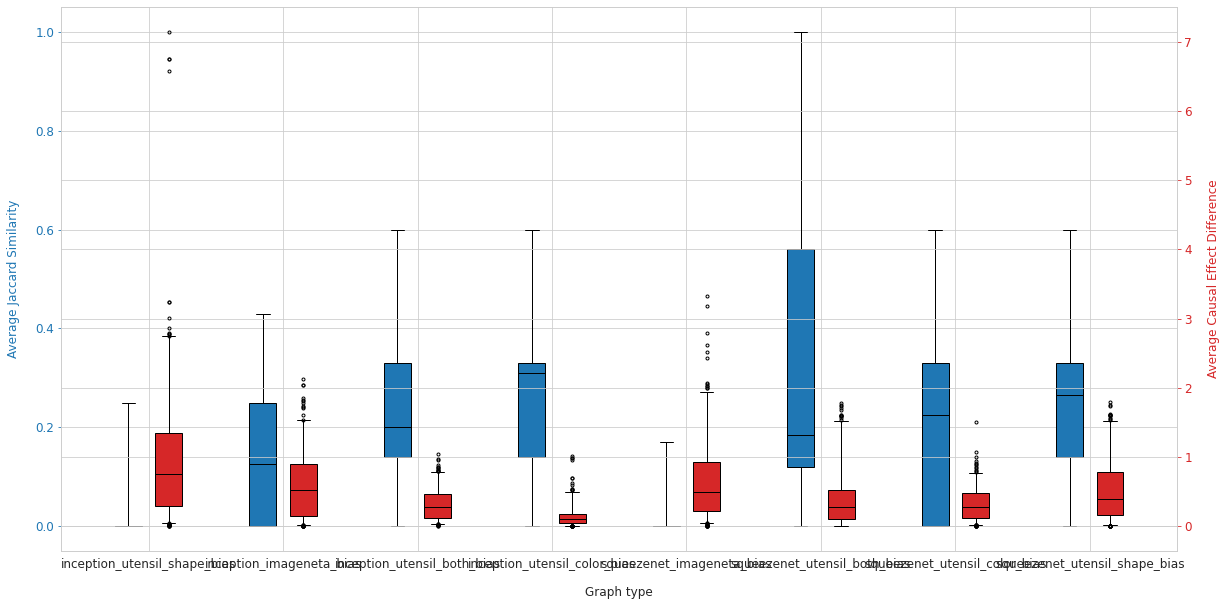

In [13]:
import numpy as np                 # v 1.19.2
import pandas as pd                # v 1.1.3
import matplotlib.pyplot as plt    # v 3.3.2

df_pivot = df.pivot(columns=['modelname'])

jaccard = [df_pivot['jaccard'][var].dropna() for var in df_pivot['jaccard']]
diff = [df_pivot['diff'][var].dropna() for var in df_pivot['diff']]

nb_groups = df['modelname'].nunique()
fig, ax1 = plt.subplots(figsize=(20,10))
box_param = dict(whis=(5, 95), widths=0.2, patch_artist=True,
                 flierprops=dict(marker='.', markeredgecolor='black',
                 fillstyle=None), medianprops=dict(color='black'))


space = 0.15
ax1.boxplot(jaccard, positions=np.arange(nb_groups)-space,
            boxprops=dict(facecolor='tab:blue'), **box_param)

ax2 = ax1.twinx()
ax2.boxplot(diff, positions=np.arange(nb_groups)+space,
            boxprops=dict(facecolor='tab:red'), **box_param)

labelsize = 12
ax1.set_xticks(np.arange(nb_groups))
ax1.set_xticklabels([f'{label}' for label in df['modelname'].unique()])
ax1.tick_params(axis='x', labelsize=labelsize)

yticks_fmt = dict(axis='y', labelsize=labelsize)
ax1.tick_params(colors='tab:blue', **yticks_fmt)
ax2.tick_params(colors='tab:red', **yticks_fmt)

label_fmt = dict(size=12, labelpad=15)
ax1.set_xlabel('Graph type', **label_fmt)
ax1.set_ylabel('Average Jaccard Similarity', color='tab:blue', **label_fmt)
ax2.set_ylabel('Average Causal Effect Difference', color='tab:red', **label_fmt)

plt.show()

In [128]:
li = []
for gt in graph_types:
    all_files = glob.glob('ch_including_shape_new/'+gt+'/*.csv')
    for filename in all_files:
        df = pd.read_csv(filename)
        df['gt'] = gt
        df.drop(columns=['Unnamed: 0'],inplace=True)
        li.append(df)

In [129]:
frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.dropna()

In [114]:
di = {'inception_imageneta_bias': "I.1",
      'inception_utensil_color_bias': "I.2", 
      "inception_utensil_shape_bias": "I.3",
      'inception_utensil_both_bias': "I.4",
      "squeezenet_imageneta_bias": "S.1",
      'squeezenet_utensil_both_bias': 'S.2',
      'squeezenet_utensil_color_bias': 'S.3',
      'squeezenet_utensil_shape_bias': 'S.4'
     }

In [130]:
frame['modelname'].replace(di, inplace=True)

In [131]:
frame.modelname.value_counts()

I.4    240
I.1    240
S.4    240
S.2    240
S.1    240
S.3    240
I.3    240
I.2    240
Name: modelname, dtype: int64

In [132]:
frame  = frame.sort_values(by='modelname')

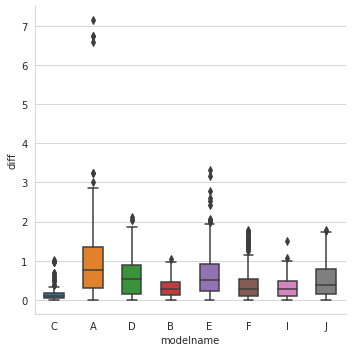

In [17]:
g = sns.catplot(x='modelname', y='diff', data=frame, kind='box', width = 0.5);

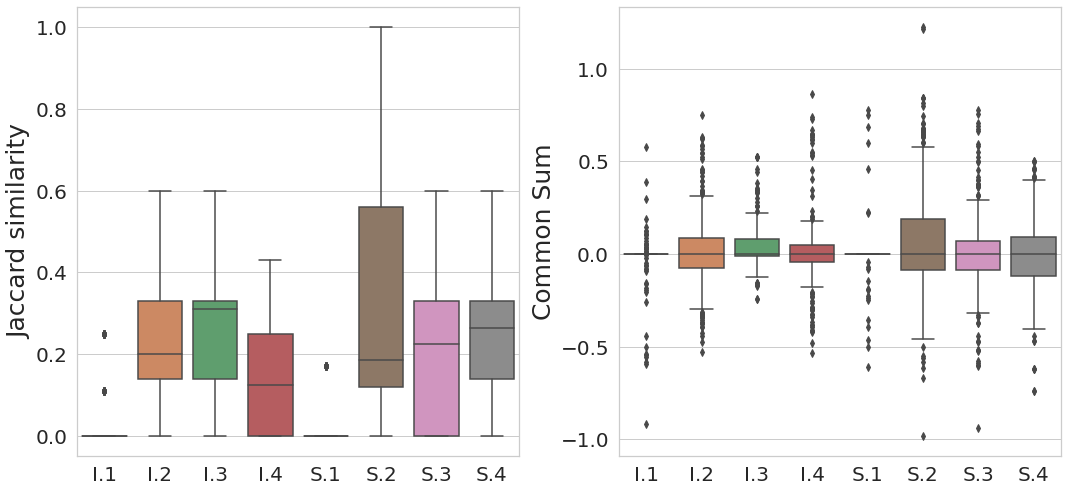

In [141]:
s = sns.set()
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2,figsize = (15,7))
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2);
# p1 = sns.boxplot(x='modelname', y='diff',  data=frame, ax=ax[0]);
p2 = sns.boxplot(x='modelname', y='jaccard', data=frame, ax=ax[0]);
p3 = sns.boxplot(x='modelname', y='common_sum', data=frame, ax=ax[1]);

for a in ax:
#     a.tick_params(labelrotation = 0, axis = 'x')
#     a.set(xlabel="",
#           ylim=(-1,1))
    for label in a.get_xticklabels():
        label.set_fontsize("20")
    for label in a.get_yticklabels():
        label.set_fontsize("20")
#     a.legend(fontsize="20")
    a.set_xticklabels(a.get_xticklabels(), ha="center")
sns.color_palette()

p1.set(xlabel=None)
p2.set(xlabel=None)
p3.set(xlabel=None)
# ax1.axes.set_title('Coherence', fontsize=20)
# ax1.set_xlabel('Model Name', fontsize=15) 
ax[0].set_ylabel('Jaccard similarity', fontsize=25)
# ax2.set_xlabel('Model Name', fontsize=15) 
ax[1].set_ylabel('Common Sum', fontsize=25)
# ax[2].set_ylabel('Common Sum', fontsize=25)

# ax2.set(xlabel='Model Name', ylabel='Jaccard Similarity')
# plt.xlabel('asa')
# fig.text(0.5, 0.009, 'common X', ha='center', fontsize=15)
fig.tight_layout();
fig.savefig("coherence.pdf", dpi=200);